# Content and Objective

+ Show result of equalization
+ you may choose a 'good' or a 'bad' channel or define one on your own

# Import

In [1]:
# importing
import numpy as np

from scipy import signal, stats

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

# define length of print output
np.set_printoptions(precision=3)

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(14, 6) )

# Some Calculations First

### Parameters

In [3]:
# constellation points are BPSK
constellation = np.array( [ -1, 1 ] )
#constellation = 1/np.sqrt(2) * np.array( [ 1+1j, 1-1j, -1+1j, -1-1j ] )
data_type = constellation.dtype

# number of symbols and samples per symbol
n_symb = 3

# samples per symbol
n_sps = 1

# snr for simulation
Es_N0_dB = 100

# pulse shaping 
# (which is quite simple here, so that we can still print some results)
g = np.array( [ .25, 1, .25 ] )
g = np.array( [1] )
print( 'Pulse shaping: ', g)

Pulse shaping:  [1]


### channel

In [4]:
# select your channel...
channel = 'ProakisB'

if channel == 'good':
    # "nice" channel
    channel_factors = [1.0, 0, .5, 0, .1]
    channel_delays_syms = np.arange( 0, len(channel_factors) )

elif channel == 'bad':
    # "bad guy" channel
    channel_factors = [1, .4, -0.3, .1, .1, .05, .05]
    channel_delays_syms = np.arange( 0, len(channel_factors) )

elif channel == 'ProakisA':
    # "nice" channel
    channel_factors = [.04, -.05, .07, -.21, -.5, .72, .36, 0, .21, .03, .07 ]
    channel_delays_syms = np.arange( 0, len(channel_factors) )

elif channel == 'ProakisB':
    # "nice" channel
    channel_factors = [ .407, .815, .407 ]
    channel_delays_syms = np.arange( 0, len(channel_factors) )

elif channel == 'my_channel':
    # here comes your code if you like to
    pass

# now map delays and attenuations to the actual impulse response
h_channel = np.zeros( ( np.max(channel_delays_syms ) + 1 ) * n_sps )

for k in np.arange(len(channel_delays_syms)):
    h_channel[ n_sps * channel_delays_syms[k] ] = channel_factors[k]

print( 'Channel: ', h_channel )

Channel:  [0.407 0.815 0.407]


### pulse shaping PLUS channel 

In [5]:
# overall impulse response x
h_0 = np.convolve( g, h_channel )

print(' Pulse shaping and channel: ', h_0)

 Pulse shaping and channel:  [0.407 0.815 0.407]


### overall impulse response

In [6]:
# now add MF at the receiver
x = np.convolve( h_0, g )

print( 'Overall impulse response: ', x )

Overall impulse response:  [0.407 0.815 0.407]


### plotting

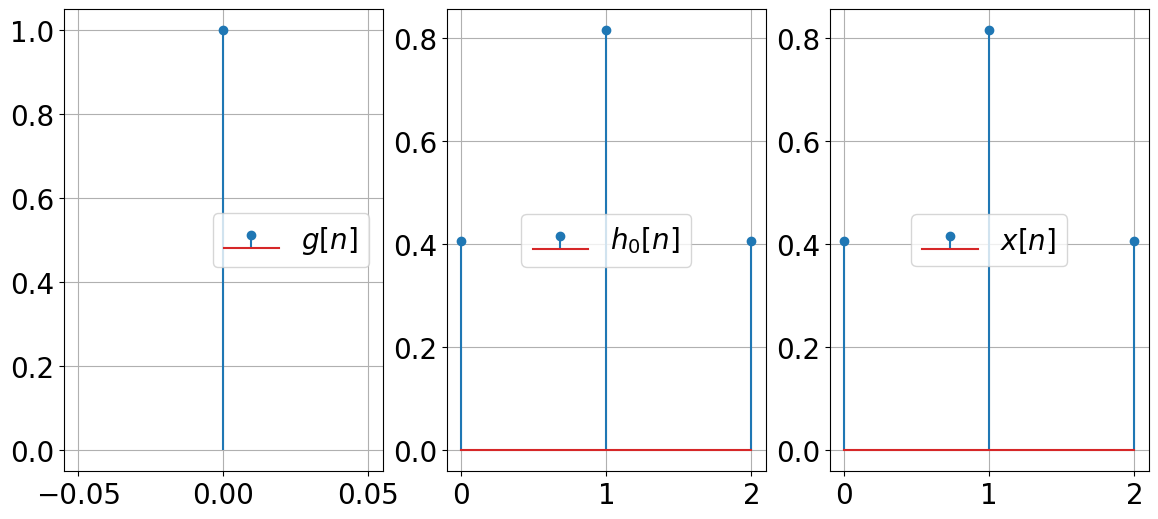

In [7]:
plt.subplot(131)
plt.stem( g, label='$g[n]$' )
plt.legend()
plt.grid(1)

plt.subplot(132)
plt.stem( h_0, label='$h_0[n]$' )
plt.legend()
plt.grid(1)

plt.subplot(133)
plt.stem( x, label='$x[n]$' )
plt.legend()
plt.grid(1)

plt.show()

### effects on the signal when multi-path channel is applied

In [8]:
# generate random BPSK symbols
s = np.random.choice( constellation, n_symb )
  
# prepare sequence to be filtered by upsampling 
s_up = np.zeros( n_symb * n_sps, dtype = data_type )        
s_up[ : : n_sps ] = s

# apply pulse shaping        
s_Tx = np.convolve( s_up, g)    

# apply channel
r_no_noise = np.convolve( s_Tx, h_channel)

# generate noise
sigma2 = 10**( - Es_N0_dB / 10 )
noise = np.sqrt( sigma2/2 ) * ( np.random.randn( len(r_no_noise) ) + 1j * np.random.randn( len(r_no_noise) ) )

if np.all( np.isreal( constellation ) ):
    noise = np.real( noise )

# add noise
r = r_no_noise + noise

# apply MF at the Rx 
y_mf = np.convolve(r, g)

print( 'symbols: ', s)


symbols:  [-1 -1 -1]


### plotting again...

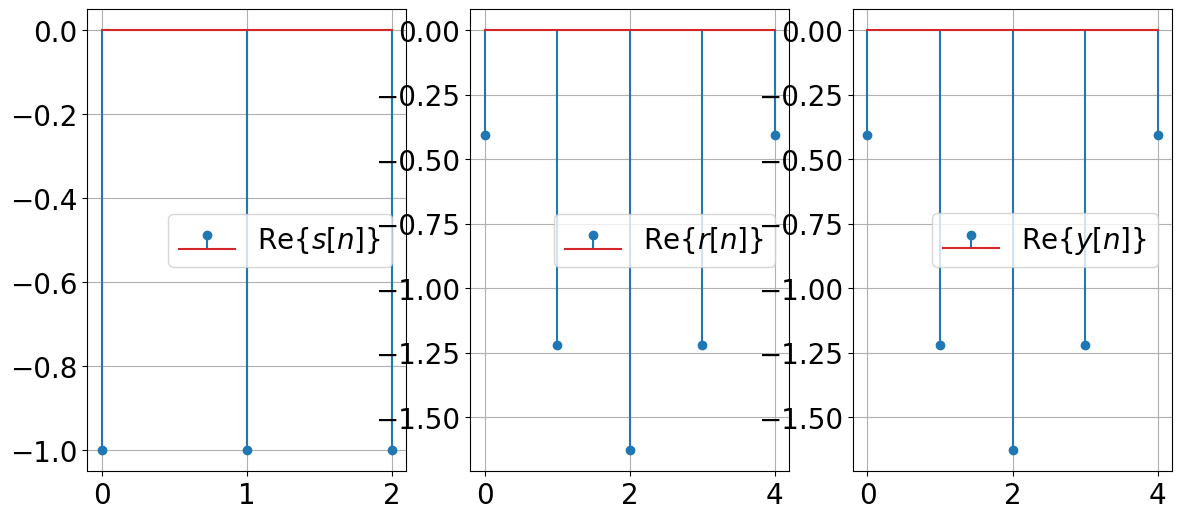

In [9]:
plt.subplot(131)
plt.stem( np.real( s_Tx ), label='Re{$s[n]$}' )
plt.legend()
plt.grid(1)

plt.subplot(132)
plt.stem( np.real( r ), label='Re{$r[n]$}' )
plt.legend()
plt.grid(1)

plt.subplot(133)
plt.stem( np.real( y_mf ), label='Re{$y[n]$}' )
plt.legend()
plt.grid(1)

plt.show()

### now get matrix of overall impulse response 

In [10]:
N_g = len( g )
N_channel = len( h_channel )
N_h_0 = len( h_0 )
N_x = len( x )
N_Tx = len( s_Tx )

X = np.zeros( ( N_x + n_symb - 1, n_symb ) )

for _n in range( X.shape[1] ):
    X[ _n : _n + N_x, _n ] = x

X = np.matrix( X )

print( 'X = \n', X)

X = 
 [[0.407 0.    0.   ]
 [0.815 0.407 0.   ]
 [0.407 0.815 0.407]
 [0.    0.407 0.815]
 [0.    0.    0.407]]


### show that matrix-vector operation results in the same signal as convolution

In [11]:
y_matrix_vector = np.matmul( X, s )

print( 'by matrix-vector multiplication: \t', y_matrix_vector)
print( 'by convolution: \t\t\t', y_mf)

by matrix-vector multiplication: 	 [[-0.407 -1.222 -1.629 -1.222 -0.407]]
by convolution: 			 [-0.407 -1.222 -1.629 -1.222 -0.407]


### now get equalizer matrices and apply them to the MF output

In [12]:
H_ZF = np.linalg.pinv( X )
H_MMSE = np.linalg.inv( X.H @ X + sigma2 * np.eye( (X.H @ X).shape[0] ) ) @ X.H

y_ZF = H_ZF @ y_mf
y_MMSE = H_MMSE @ y_mf

print( 'symbols: \t\t', s)
print( 'result of ZF: \t\t', y_ZF)
print( 'result of MMSE: \t', y_MMSE)


symbols: 		 [-1 -1 -1]
result of ZF: 		 [[-1. -1. -1.]]
result of MMSE: 	 [[-1. -1. -1.]]


### show constellation points

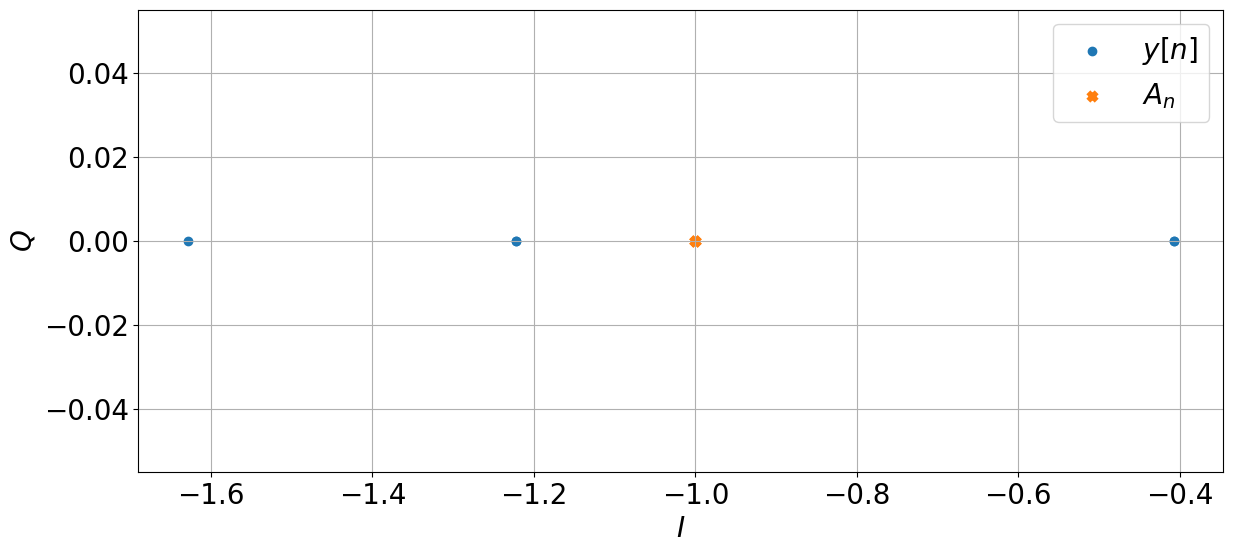

In [13]:
plt.scatter( np.real( y_mf ), np.imag( y_mf ), label='$y[n]$' )
plt.scatter( np.real( s ), np.imag( s ), marker='x', linewidth=4, label='$A_n$' )
plt.xlabel('$I$')
plt.ylabel('$Q$')
plt.grid(1)
plt.legend()
plt.show()

# Now Simulation of SER

### some parameters

In [14]:
# snr values
Es_N0_dB = np.arange( 0, 21, 4)

# number of max symbols and errors
max_syms = int( 1e6 )
max_errors = 200 

# packet size
# NOTE: we are introducing packet size here to transmit symbols in blocks,
#       thereby allowing for simple application of the equalization operation
L = 20

# get new shaped X
X = np.zeros( ( N_x + L - 1, L ) )

for _n in range( X.shape[1] ):
    X[ _n : _n + N_x, _n ] = x

X = np.matrix( X )

### actual simulation

In [15]:
# init ser
ser_AWGN = np.zeros( len( Es_N0_dB ) ) 
ser_ZF = np.zeros( len( Es_N0_dB ) )    
ser_MMSE = np.zeros( len( Es_N0_dB ) )    


# loop for snr
for ind_snr, val_snr in enumerate( Es_N0_dB ):

    # noise variance and error counter
    sigma2 = 10**( - val_snr / 10 ) 

    numb_syms = 0 
    numb_errors_AWGN = 0
    numb_errors_ZF = 0
    numb_errors_MMSE = 0
    
    # get matrices for equalization
    H_ZF = np.linalg.pinv( X )
    H_MMSE = np.linalg.inv( X.H @ X + sigma2 * np.eye( (X.H @ X).shape[0] ) ) @ X.H


    # loop for symbols    
    while numb_syms < max_syms and numb_errors_MMSE < max_errors:
    
        # generate random BPSK symbols
        s = np.random.choice( constellation, L )
        
        # prepare sequence to be filtered by upsampling 
        s_up = np.zeros( L * n_sps, dtype = data_type )        
        s_up[ : : n_sps ] = s

        # apply pulse shaping        
        s_Tx = np.convolve( s_up, g )    

        # apply channel
        r_no_noise = np.convolve( s_Tx, h_channel )

        # generate noise
        noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn( len(r_no_noise) ) + 1j * np.random.randn( len(r_no_noise) ) )

        if np.all( np.isreal( constellation ) ):
            noise = np.real( noise )

        # add noise
        r = r_no_noise + noise

        # apply MF at the Rx 
        y_mf = np.convolve(r, g)

        # now reduce to the symbol times, demodulate in awgn, and count errors
        K_filt = len( g )
        y_down = y_mf[ K_filt-1 : K_filt-1 + L * n_sps : n_sps ]
        demod_AWGN = np.array( [ constellation[ ( np.abs( constellation - y_temp )**2 ).argmin() ] for y_temp in y_down ] )
        numb_errors_AWGN += L - np.sum( (np.isclose( demod_AWGN, s ) ).astype(int) )

        # demod after ZF and count errors
        y_ZF = np.array( H_ZF @ y_mf )
        y_ZF = np.squeeze( y_ZF )
        
        demod_ZF = np.array( [ constellation[ ( np.abs( constellation - y_temp )**2 ).argmin() ] for y_temp in y_ZF ] )
        numb_errors_ZF += L - np.sum( (np.isclose( demod_ZF, s ) ).astype(int) )
        
        # demod after MMSE and count errors
        y_MMSE = np.array( H_MMSE @ y_mf )
        y_MMSE = y_MMSE.reshape( -1)
        demod_MMSE = np.array( [ constellation[ ( np.abs( constellation - y_temp )**2 ).argmin() ] for y_temp in y_MMSE ] )
        numb_errors_MMSE += L - np.sum( (np.isclose( demod_MMSE, s ) ).astype(int) )

        # increase symbol counter
        numb_syms += L

    # calculate error rates
    ser_AWGN[ ind_snr ] = numb_errors_AWGN / numb_syms
    ser_ZF[ ind_snr ] = numb_errors_ZF / numb_syms
    ser_MMSE[ ind_snr ] = numb_errors_MMSE / numb_syms

    # show progress
    print( 'Done: {:2.2f} dB'.format( val_snr ) )

Done: 0.00 dB
Done: 4.00 dB
Done: 8.00 dB
Done: 12.00 dB
Done: 16.00 dB
Done: 20.00 dB


### plotting

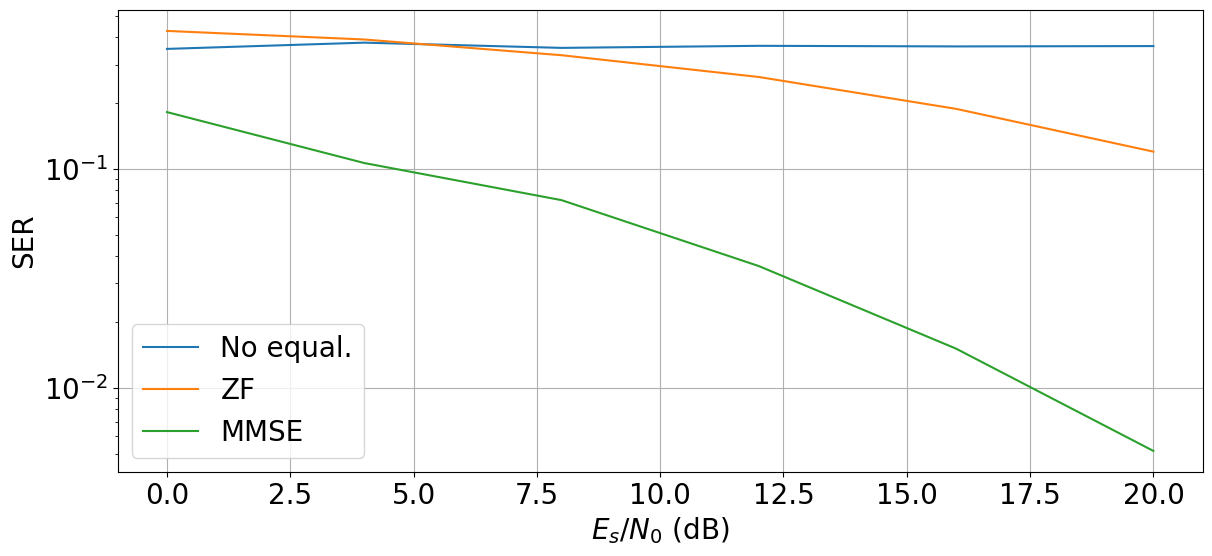

In [16]:
plt.semilogy( Es_N0_dB, ser_AWGN, label='No equal.')
plt.semilogy( Es_N0_dB, ser_ZF, label='ZF')
plt.semilogy( Es_N0_dB, ser_MMSE, label='MMSE')

plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('SER')
plt.legend()
plt.grid(1)
plt.show()